#UNIVERSIDADE FEDERAL DO RIO GRANDE DO NORTE

#CENTRO DE TECNOLOGIA

#DEPARTAMENTO DE ENGENHARIA DE COMPUTAÇÃO E AUTOMAÇÃO


##**Projeto 2 - Pequenos Mundos**

Docente: IVANOVITCH MEDEIROS DANTAS DA SILVA

Discenctes: Sidney Alves e Thiago Rodrigues

##**Importando bibliotecas e dados**

In [1]:
!pip install nxviz==0.6.3
!pip install matplotlib
!pip install pandas==1.3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pandas-1.3.0.tar.gz (4.7 MB)
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import nxviz as nv
import seaborn as sns
import pandas as pd

In [3]:
!git clone https://github.com/alvarofpp/dataset-flights-brazil
!git clone https://github.com/ip2location/ip2location-iata-icao

fatal: destination path 'dataset-flights-brazil' already exists and is not an empty directory.
fatal: destination path 'ip2location-iata-icao' already exists and is not an empty directory.


In [4]:
air_traffic = nx.read_graphml('/content/dataset-flights-brazil/data/air_traffic.graphml')

In [5]:
airports_df = pd.read_csv('/content/dataset-flights-brazil/data/airports.csv')
flights_df = pd.read_csv('/content/dataset-flights-brazil/data/anac.zip')

##**Requerimento 1 - Estudo sobre assortatividade**

**Para gerar o gráfico, temos que adicionar 'region' aos nós.**

```
for index, row in airports_df.iterrows():
    Graph.add_node(row['code'],
               name=row['name'],
               country=row['country'],
               region=row['region'],
               state=row['state'] #linha adicionada
               )
```

In [6]:
Gn = nx.Graph()

for index, row in airports_df.iterrows():
    Gn.add_node(row['code'],
               name=row['name'],
               country=row['country'],
               region=row['region'],
               state=row['state']
               )

**Convertendo float para str**

In [7]:
for node in Gn.nodes():
  Gn.nodes[node]['region'] = str(Gn.nodes[node]['region'])

**Adicionando adges**

In [8]:
edges_df = flights_df[[
    'origin_airport_abbreviation',
    'destination_airport_abbreviation'
]].dropna()

In [9]:
edges_df = edges_df.groupby(edges_df.columns.tolist(), as_index=False).size()

In [10]:
for _, row in edges_df.iterrows():
    if row['origin_airport_abbreviation'] == row['destination_airport_abbreviation']:
        continue
    Gn.add_edge(row['origin_airport_abbreviation'], row['destination_airport_abbreviation'], flight_count=row['size'])

**Removendo NAN**

In [11]:
list_rm = []
for index in range(len(airports_df['region'])):
	if type(airports_df['region'][index]) == type(float(0)) or airports_df['region'][index]=='NÃO IDENTIFICADO':
		list_rm.append(list(airports_df['code'])[index])

In [12]:
Gn.remove_nodes_from(list_rm)

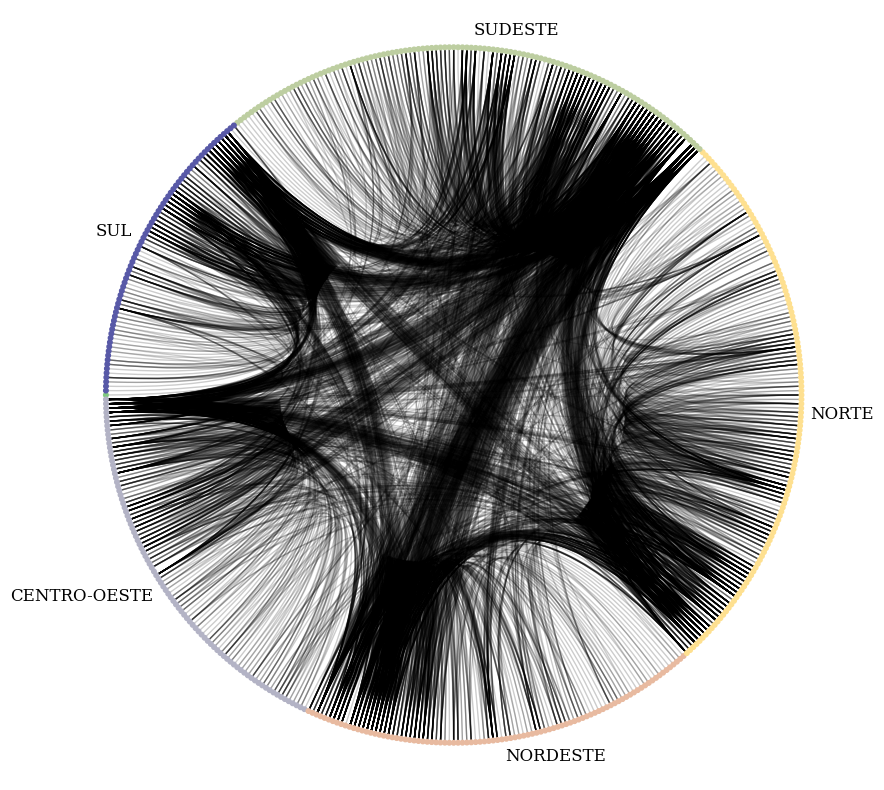

In [13]:
c = nv.CircosPlot(Gn, 
      node_color='region',
			node_grouping='region',
			node_order='region',
			node_labels=False,
			group_label_position='middle',
			group_label_color=False,
			figsize=(12,8),
			nodeprops={'radius':0.7},
			fontsize=12)

c.draw()
c.figure.tight_layout()

plt.show()

**Filtrando os vôos por nacionalidade, no caso filtrando pelos vôos no Brasil**

In [14]:
air_brazil = []
for node in Gn.nodes():
  if Gn.nodes[node]['country'] == 'BRASIL':
    air_brazil.append(node)

airports_brazil = Gn.subgraph(air_brazil)

**Calculando a assortatividade**

In [15]:
assortativity = nx.attribute_assortativity_coefficient(airports_brazil, 'region')
print(f'Assortatividade: {assortativity}.')

Assortatividade: 0.36728130173582757.


Nós tendem a se conectarem por possuirem atributos em comum, uma vez que o valor de ```assortativity``` se aproxima de 1.

**Matriz com probabilidade de conexões**

In [16]:
mixing_matrix = nx.attribute_mixing_matrix(airports_brazil,'region')
mixing_matrix

array([[0.06905952, 0.04009541, 0.00726942, 0.01317583, 0.01226715],
       [0.04009541, 0.17446615, 0.02782826, 0.05599727, 0.03441617],
       [0.00726942, 0.02782826, 0.13584734, 0.02078601, 0.02226261],
       [0.01317583, 0.05599727, 0.02078601, 0.07882781, 0.01067697],
       [0.01226715, 0.03441617, 0.02226261, 0.01067697, 0.05224898]])

Probabilidade de conexões entre os nós, além de que a diagonal principal possue maiores valores, representando as conexões dos aeroportos das mesmas regiões.

##**Requerimento 2 - Análise bivariada**

Observando a correlação entre os graus dos nós e a média do grau dos seus vizinhos, utilizamos do coeficiente de assortatividade em relação ao grau para analizar as relações entre as regiões. Tivemos como resultado coesficientes negativos, representando que os aeroportos de uma região devem estar conectados a outros aeroportos de outras regiões.

**Brasil**

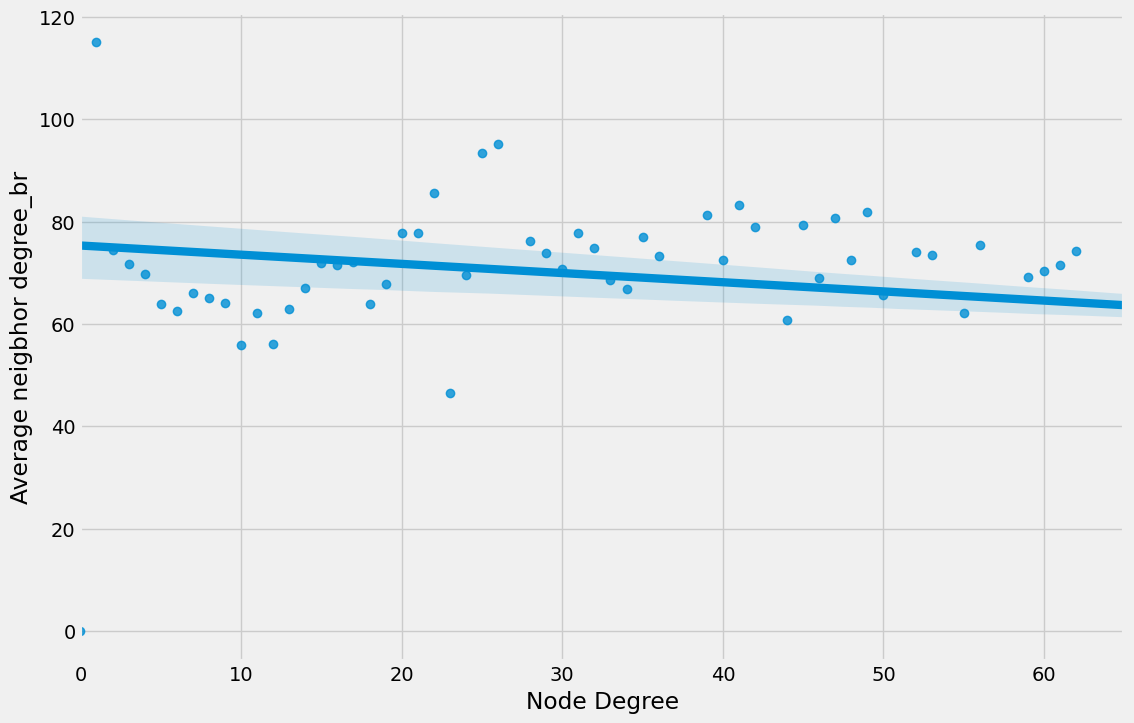

In [17]:
degree_br, avg_neigh_degree_br = zip(*nx.average_degree_connectivity(Gn).items())
degree_br = list(degree_br)
avg_neigh_degree_br = list(avg_neigh_degree_br)

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize=(12,8))

sns.regplot(x=degree_br,y=avg_neigh_degree_br,ax=ax)

ax.set_xlabel("Node Degree")
ax.set_ylabel("Average neigbhor degree_br")
ax.set_xlim(0,65)

plt.show();

In [18]:
nx.degree_assortativity_coefficient(airports_brazil)

-0.2017097172979742

**Norte**

In [19]:
Norte = []
for node in Gn.nodes():
  if Gn.nodes[node]['region'] == 'NORTE':
    Norte.append(node)
north_region =  Gn.subgraph(Norte)

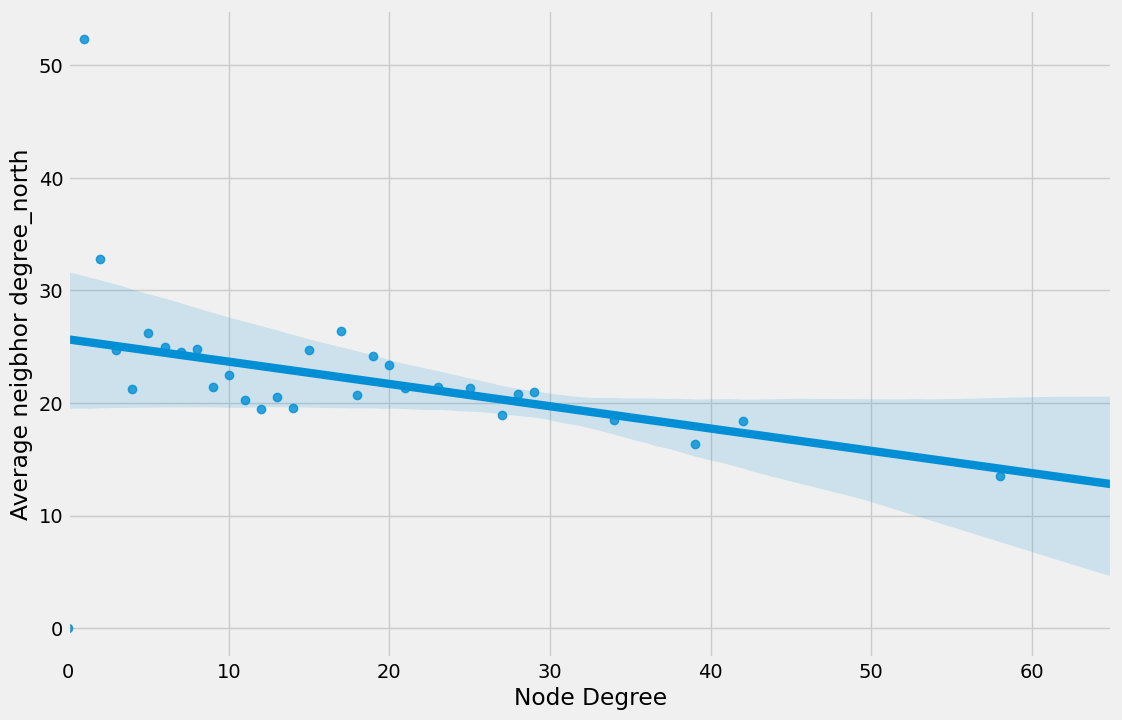

In [20]:
degree_north, avg_neigh_degree_north = zip(*nx.average_degree_connectivity(north_region).items())

degree_north = list(degree_north)
avg_neigh_degree_north = list(avg_neigh_degree_north)

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize=(12,8))

sns.regplot(x=degree_north,y=avg_neigh_degree_north,ax=ax)

ax.set_xlabel("Node Degree")
ax.set_ylabel("Average neigbhor degree_north")
ax.set_xlim(0,65)

plt.show()

In [21]:
nx.degree_assortativity_coefficient(north_region)

-0.22193985877089423

**Nordeste**

In [22]:
Nordeste = []
for node in Gn.nodes():
  if Gn.nodes[node]['region'] == 'NORDESTE':
    Nordeste.append(node)
northeast_region =  Gn.subgraph(Nordeste)

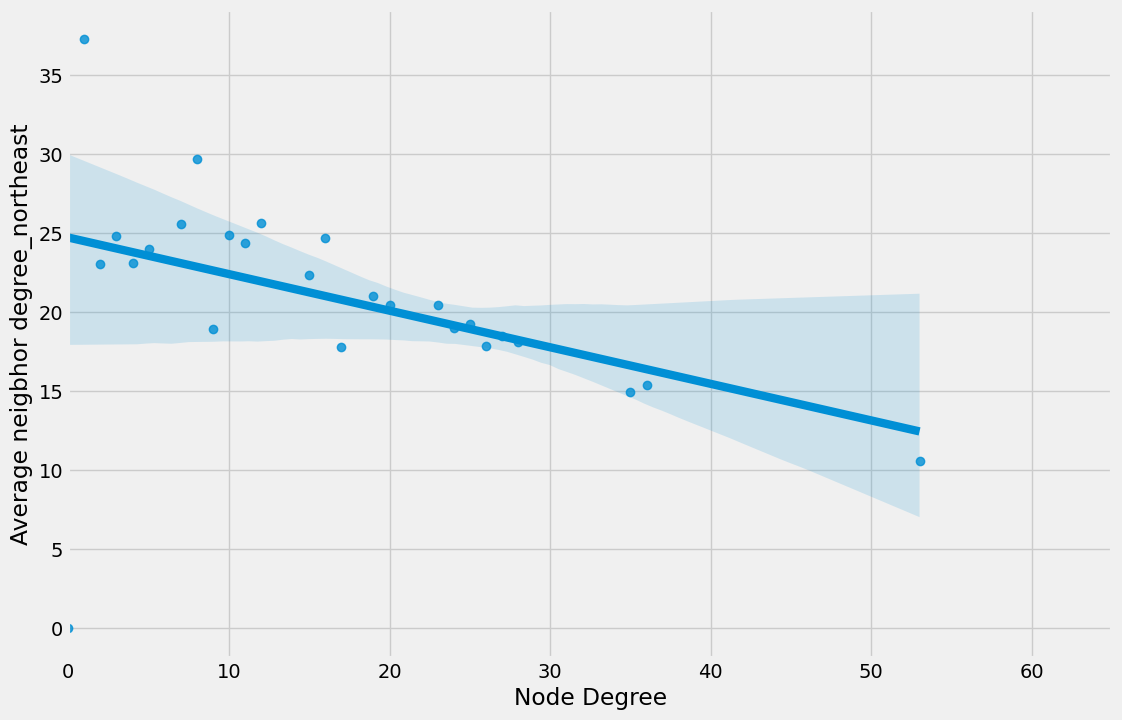

In [23]:
degree_northeast, avg_neigh_degree_northeast = zip(*nx.average_degree_connectivity(northeast_region).items())

degree_northeast = list(degree_northeast)
avg_neigh_degree_northeast = list(avg_neigh_degree_northeast)

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize=(12,8))

sns.regplot(x=degree_northeast,y=avg_neigh_degree_northeast,ax=ax)

ax.set_xlabel("Node Degree")
ax.set_ylabel("Average neigbhor degree_northeast")
ax.set_xlim(0,65)

plt.show()

In [24]:
nx.degree_assortativity_coefficient(northeast_region)

-0.33375735918340366

**Sudeste**

In [25]:
Sudeste = []
for node in Gn.nodes():
  if Gn.nodes[node]['region'] == 'SUDESTE':
    Sudeste.append(node)
southeast_region =  Gn.subgraph(Sudeste)

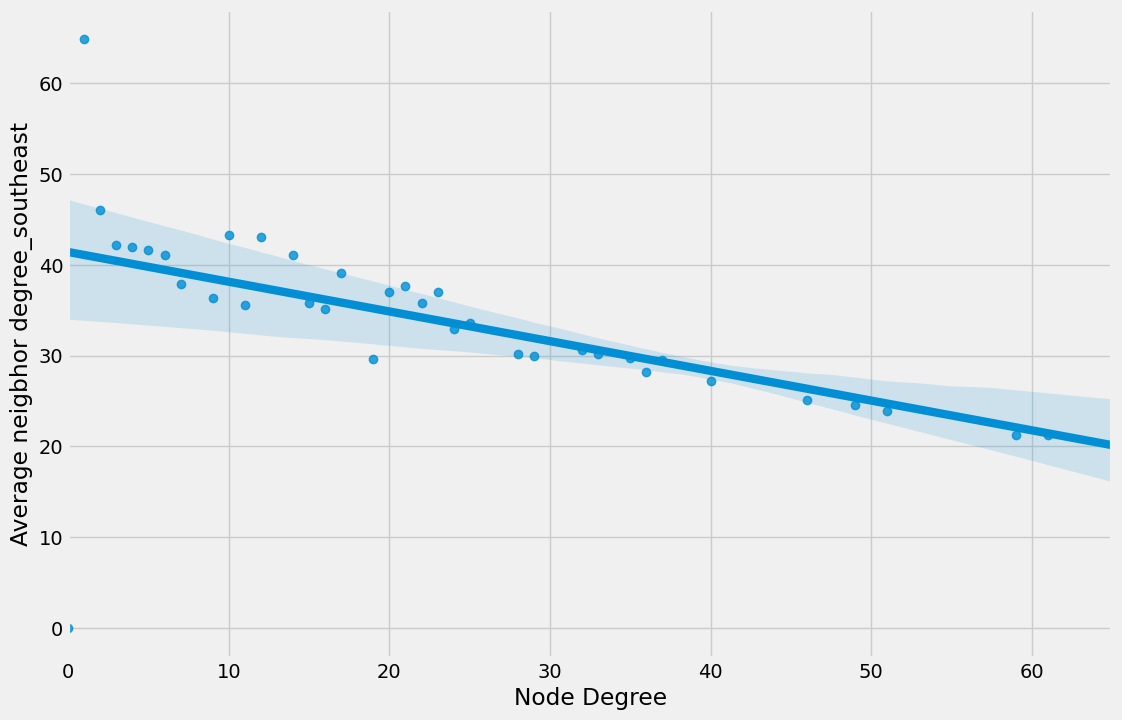

In [26]:
degree_southeast, avg_neigh_degree_southeast = zip(*nx.average_degree_connectivity(southeast_region).items())

degree_southeast = list(degree_southeast)
avg_neigh_degree_southeast = list(avg_neigh_degree_southeast)

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize=(12,8))

sns.regplot(x=degree_southeast,y=avg_neigh_degree_southeast,ax=ax)

ax.set_xlabel("Node Degree")
ax.set_ylabel("Average neigbhor degree_southeast")
ax.set_xlim(0,65)

plt.show()

In [27]:
nx.degree_assortativity_coefficient(southeast_region)

-0.3687746079424212

**Sul**

In [28]:
Sul = []
for node in Gn.nodes():
  if Gn.nodes[node]['region'] == 'SUL':
    Sul.append(node)
south_region =  Gn.subgraph(Sul)

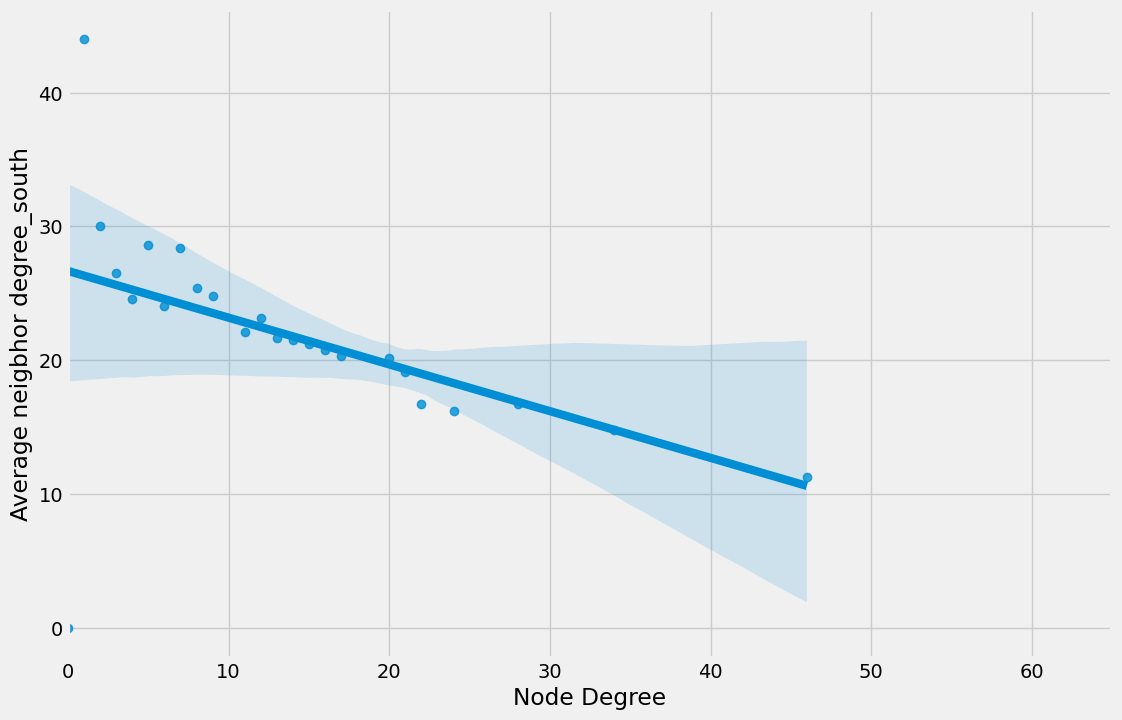

In [29]:
degree_south, avg_neigh_degree_south = zip(*nx.average_degree_connectivity(south_region).items())

degree_south = list(degree_south)
avg_neigh_degree_south = list(avg_neigh_degree_south)

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize=(12,8))

sns.regplot(x=degree_south,y=avg_neigh_degree_south,ax=ax)

ax.set_xlabel("Node Degree")
ax.set_ylabel("Average neigbhor degree_south")
ax.set_xlim(0,65)

plt.show()

In [30]:
nx.degree_assortativity_coefficient(south_region)

-0.40181381306857755

**Centro Oeste**

In [31]:
Centro = []
for node in Gn.nodes():
  if Gn.nodes[node]['region'] == 'CENTRO-OESTE':
    Centro.append(node)
midwest_region =  Gn.subgraph(Centro)

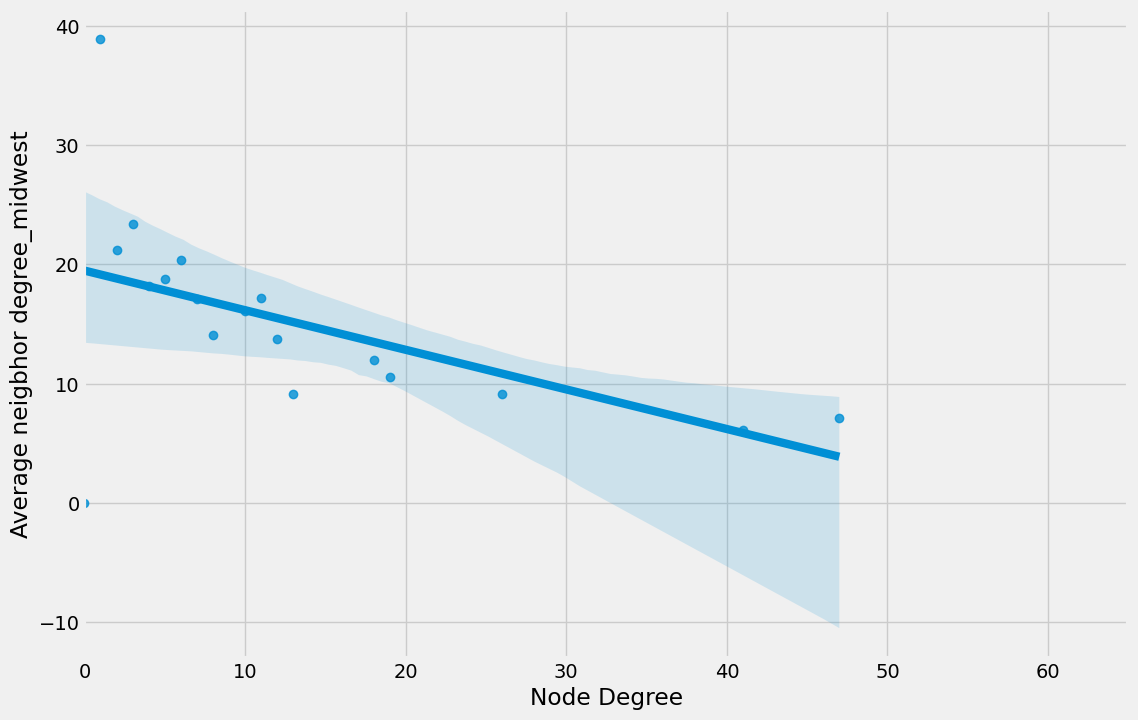

In [32]:
degree_midwest, avg_neigh_degree_midwest = zip(*nx.average_degree_connectivity(midwest_region).items())

degree_midwest = list(degree_midwest)
avg_neigh_degree_midwest = list(avg_neigh_degree_midwest)

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize=(12,8))

sns.regplot(x=degree_midwest,y=avg_neigh_degree_midwest,ax=ax)

ax.set_xlabel("Node Degree")
ax.set_ylabel("Average neigbhor degree_midwest")
ax.set_xlim(0,65)

plt.show()

In [33]:
nx.degree_assortativity_coefficient(midwest_region)

-0.3542839902086467

##**Requerimento 3 - Componentes conectados**

**Quantidade de aeroportos por região**

In [34]:
region_group = airports_df.groupby(['region'])['name'].count().reset_index(name='count')
region_group

,region,count
0,,1
1,CENTRO-OESTE,89
2,NORDESTE,92
3,NORTE,128
4,NÃO IDENTIFICADO,1
5,SUDESTE,116
6,SUL,70


**Componente que está em todas as regiões**

In [35]:
for component in nx.connected_components(Gn):
  region_comp = component
  break
print(region_comp)

{'SNRS', 'SSBB', 'SBZM', 'SWTU', 'SBQV', 'SWWA', 'SBJE', 'SSTL', 'SSSC', 'SBRF', 'SBLO', 'SDPA', 'SSLS', 'SSBN', 'SNOS', 'SNTP', 'SNKI', 'SWEE', 'SNDR', 'SNJO', 'SBIC', 'SSNM', 'SDAN', 'SDMC', 'SNBV', 'SDUB', 'SBBE', 'SBTK', 'SBMQ', 'SSFB', 'SBCA', 'SNDB', 'SDOU', 'SBAS', 'SWDM', 'SSEP', 'SWPQ', 'SNKB', 'SWOB', 'SBSI', 'SWFE', 'SNBS', 'SWJU', 'SBAF', 'SIFV', 'SWXV', 'SNPV', 'SBGU', 'SBPP', 'SNTO', 'SBMH', 'SBMG', 'SSUV', 'SSPK', 'SSOU', 'SWII', 'SJKB', 'SBHT', '2NHT', 'SBAN', 'SNMU', 'SNAX', 'SNMA', 'SNIP', 'SNCI', 'SBAT', 'SSVL', 'SWYK', 'SBYA', 'SBJR', 'SBTT', 'SIRI', 'KDAL', 'SSPG', 'SWLF', 'SDAA', 'SWLB', 'SSPB', 'SNUU', 'SNPG', 'SBKG', 'SBJI', 'SBPI', 'SBYS', 'SBRJ', 'SWCB', 'SBCN', 'SBEG', 'SBUL', 'SNJK', 'SDSC', 'SNSG', 'SBCX', 'SNTS', 'SWFJ', 'SWBC', 'SBSJ', 'SDVG', 'SBSG', 'SNYB', 'SNMZ', 'SBVC', 'SBJU', 'SWLC', 'SBCF', 'SBCC', 'SJDB', 'SJLU', 'SNXL', 'SBSV', 'SNTI', 'SIKC', 'SSRS', 'SSJA', 'SWNS', 'SBMA', 'SNBI', 'SBIT', 'SDCO', 'SNBR', 'SNUH', 'SBTD', 'SBMO', 'SNFE', 'SSCC',

**Regiões que pertencem ao componente**

In [36]:
region_comp_df = pd.DataFrame(region_comp,columns=['code'])

In [37]:
airports_merge = pd.merge(airports_df,region_comp_df,on='code',how='inner')

In [38]:
airports_merge_group = airports_merge.groupby('region')['code'].count().reset_index(name='max_count')
airports_merge_group

,region,max_count
0,,1
1,CENTRO-OESTE,88
2,NORDESTE,92
3,NORTE,126
4,SUDESTE,115
5,SUL,70


In [39]:
resultC = (airports_merge_group['max_count'][1] / region_group['count'][1]) * 100 
result = round(resultC,2)
print('Centro-Oeste: {} %'.format(result))

Centro-Oeste: 98.88 %


In [40]:
resultND = (airports_merge_group['max_count'][2] / region_group['count'][2]) * 100 
result = round(resultND,2)
print('Nordeste: {} %'.format(result))

Nordeste: 100.0 %


In [41]:
resultN = (airports_merge_group['max_count'][3] / region_group['count'][3]) * 100 
result = round(resultN,2)
print('Norte: {} %'.format(result))

Norte: 98.44 %


In [42]:
resultSD = (airports_merge_group['max_count'][4] / region_group['count'][5]) * 100 
result = round(resultSD,2)
print('Sudeste: {} %'.format(result))

Sudeste: 99.14 %


In [43]:
resultS = (airports_merge_group['max_count'][5] / region_group['count'][6]) * 100 
result = round(resultS,2)
print('Sul: {} %'.format(result))

Sul: 100.0 %


##**Requerimento 4 - Caminho mais curto**

In [44]:
!pip install --no-binary shapely shapely --force
!pip install cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached shapely-2.0.1-cp310-cp310-linux_x86_64.whl
  Using cached numpy-1.24.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.1
    Uninstalling shapely-2.0.1:
      Successfully uninstalled shapely-2.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
!git clone https://github.com/ip2location/ip2location-iata-icao

fatal: destination path 'ip2location-iata-icao' already exists and is not an empty directory.


In [46]:
import pandas as pd
import numpy as np
import folium
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from matplotlib.patches import FancyArrowPatch

**Filtrando os aeroportos brasileiros da base de dados aeroportos brasileiros**

In [47]:
airports_br_df = airports_df[airports_df.country == 'BRASIL']
airports_br_df.head()

,code,name,state,region,country,continent,Código OACI,lat_geo_point,lon_geo_point
3,SBCF,CONFINS,MG,SUDESTE,BRASIL,AMÉRICA DO SUL,NaN,-19.62444305419922,-43.97194290161133
4,SBGL,RIO DE JANEIRO,RJ,SUDESTE,BRASIL,AMÉRICA DO SUL,NaN,-22.8099994659,-43.2505569458
5,SBGR,GUARULHOS,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,NaN,-23.435556411743164,-46.47305679321289
7,SSUM,UMUARAMA,PR,SUL,BRASIL,AMÉRICA DO SUL,NaN,-23.7987003326416,-53.31380081176758
10,SNBG,BAIXO GUANDU,ES,SUDESTE,BRASIL,AMÉRICA DO SUL,NaN,-19.499000549316406,-41.04180145263672


**Selecionando aeroporto aleatório para cada região**

In [48]:
np.random.seed(123)

In [49]:
# Randomly picking 5 airports for the route by region
route_regions = ['NORTE', 'SUL', 'NORDESTE', 'CENTRO-OESTE', 'SUDESTE']
air_route = []
for region in route_regions:
  subset_df = airports_br_df[airports_br_df.region == region]
  airport_pick = subset_df.sample().iloc[0, 0] 
  air_route.append(airport_pick)
  print(region, '->', airport_pick)

print('\nRoute:', air_route)

NORTE -> SBCJ
SUL -> SSUM
NORDESTE -> SBFN
CENTRO-OESTE -> SWFE
SUDESTE -> SNJR

Route: ['SBCJ', 'SSUM', 'SBFN', 'SWFE', 'SNJR']


**Caminho mais curto para a rota a ser percorrida entre as regiões**

In [50]:
full_route = [air_route[0]]
for i in range(len(air_route)-1):
    leg = nx.shortest_path(airports_brazil, air_route[i], air_route[i+1])
    print(air_route[i], '->', air_route[i+1], leg)
    full_route.extend(leg[1:])
print('\nFull Route', full_route)

SBCJ -> SSUM ['SBCJ', 'SBCT', 'SSUM']
SSUM -> SBFN ['SSUM', 'SBCT', 'SBFN']
SBFN -> SWFE ['SBFN', 'SBAR', 'SBCY', 'SWFE']
SWFE -> SNJR ['SWFE', 'SBCY', 'SBBH', 'SNJR']

Full Route ['SBCJ', 'SBCT', 'SSUM', 'SBCT', 'SBFN', 'SBAR', 'SBCY', 'SWFE', 'SBCY', 'SBBH', 'SNJR']


In [51]:
pose = dict()
for node in full_route:
    pose[node] = np.array([air_traffic.nodes[node]['longitude'].replace(',','.'),
                           air_traffic.nodes[node]['latitude'].replace(',','.')], dtype='float64')

In [52]:
route_subgraph = air_traffic.subgraph(full_route).to_directed()
route_graph = nx.create_empty_copy(route_subgraph)

for i in range(len(full_route)-1):
    route_graph.add_edge(full_route[i], full_route[i+1])

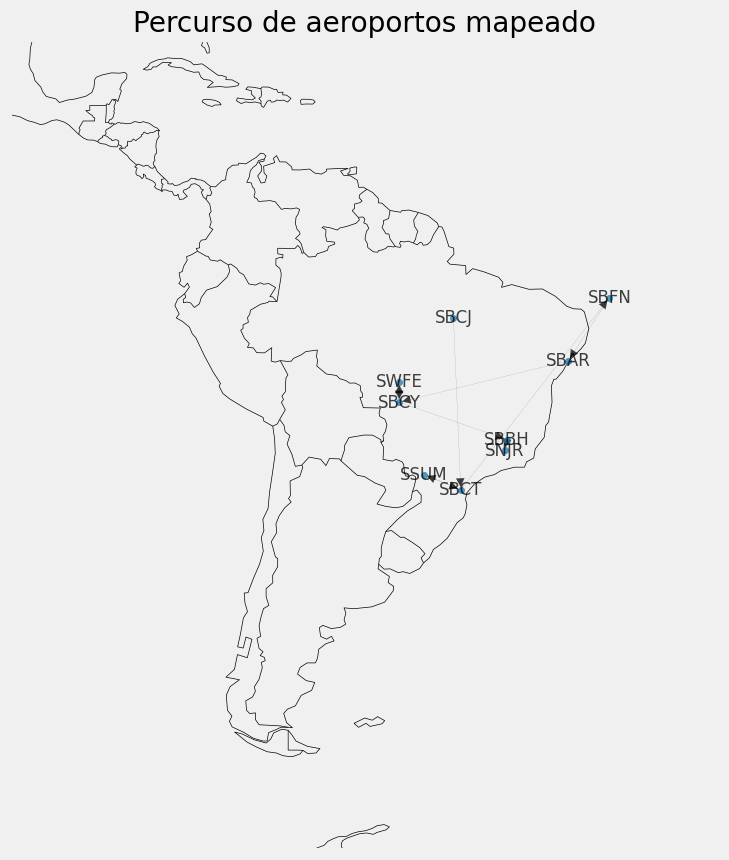

Aeroportos de Destino: ['SBCJ', 'SSUM', 'SBFN', 'SWFE', 'SNJR']
Caminho Completo com Paradas: ['SBCJ', 'SBCT', 'SSUM', 'SBCT', 'SBFN', 'SBAR', 'SBCY', 'SWFE', 'SBCY', 'SBBH', 'SNJR']


In [53]:
# Map projection
crs = ccrs.PlateCarree(central_longitude=0)
fig, ax = plt.subplots(
    1, 1, figsize=(15, 10),
    subplot_kw=dict(projection=crs))
ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.set_extent([-100, -20, -60, 20])
ax.set_title("Percurso de aeroportos mapeado")

nx.draw_networkx(route_graph, ax=ax,
                 font_size=12,
                 alpha=0.75,
                 width=.075,
                 node_size=20,
                 arrowsize=15,
                 pos=pose)


plt.show()
print('Aeroportos de Destino:', air_route)
print('Caminho Completo com Paradas:', full_route)

##**Requerimento 5 - Coeficiente de Clustering**

**Brasil**

In [54]:
trianglesBR = nx.triangles(airports_brazil);

In [55]:
clusteringBR = nx.clustering(airports_brazil);

In [56]:
averageBR = nx.average_clustering(airports_brazil)
print(f'Agrupamento médio = {averageBR}')

Agrupamento médio = 0.623050800236936


**Norte**

In [57]:
trianglesNor = nx.triangles(north_region)

In [58]:
clusteringNor = nx.clustering(north_region)

In [59]:
averageNor = nx.average_clustering(north_region)
print(f'Agrupamento médio = {averageNor}')

Agrupamento médio = 0.6159653188854739


**Nordeste**

In [60]:
trianglesND = nx.triangles(northeast_region)

In [61]:
clusteringND = nx.clustering(northeast_region)

In [62]:
averageND = nx.average_clustering(northeast_region)
print(f'Agrupamento médio = {averageND}')

Agrupamento médio = 0.43807384418290285


**Suldeste**

In [63]:
trianglesSD = nx.triangles(southeast_region)

In [64]:
clusteringSD = nx.clustering(southeast_region)

In [65]:
averageSD = nx.average_clustering(southeast_region)
print(f'Agrupamento médio = {averageSD}')

Agrupamento médio = 0.6186700538769272


**Sul**

In [66]:
trianglesS = nx.triangles(south_region)

In [67]:
clusteringS = nx.clustering(south_region)

In [68]:
averageS = nx.average_clustering(south_region)
print(f'Agrupamento médio = {averageS}')

Agrupamento médio = 0.5979416718387066


**Centro-Oeste**

In [69]:
trianglesC = nx.triangles(midwest_region)

In [70]:
clusteringC = nx.clustering(midwest_region)

In [71]:
averageC = nx.average_clustering(midwest_region)
print(f'Agrupamento médio = {averageC}')

Agrupamento médio = 0.5618772358860067
